# Socioeconomic Clustering of U.S. Adults (Unsupervised Learning Project)

In recent decades, socioeconomic inequality has been a central issue in both public policy and academic research. Income disparities are shaped not only by individual attributes like age, gender, and education, but also by broader structural factors such as occupational roles, marital status, and systemic bias in access to high-paying jobs. The dataset Adult offers a great intuition of these dynamics, capturing a range of demographic and employment-related variables for thousands of individuals.

## Objective

This project aims to uncover **latent socioeconomic groupings** in the U.S. adult population using **unsupervised learning** techniques.  
Specifically, we use **k-means clustering** on the Adult dataset (from the UCI Machine Learning Repository) to segment individuals based on attributes such as:

- Age  
- Education level  
- Marital status  
- Work hours per week  
- Occupation
- Work class
- Capital gains/losses
- Sex
- Race

We **exclude the income label** (`>50K` or `<=50K`) from the clustering process in order to discover natural structure in the data without supervision.  
Later, we analyze how the resulting clusters relate to income, which helps validate the usefulness of the segmentation.

## Research Question

> **What distinct groups of adults exist in the dataset based on their demographic, educational, and work characteristics?**

Understanding these segments can provide insight for:
- Policy-makers designing programs for different population groups
- Businesses targeting customers with tailored services
- Data scientists looking to engineer informative group-level features for supervised learning

## Acknowledgements/Reference
- This dataset is found in the UCI machine learning repository
    - https://archive.ics.uci.edu/dataset/2/adult
    - https://www.cs.toronto.edu/~delve/data/adult/desc.html
- There are also detailed description of the dataset in this link
    - https://www.cs.toronto.edu/~delve/data/adult/adultDetail.html
## Tools

- **Python**  
- **scikit-learn**: k-means, preprocessing, PCA  
- **pandas**: data wrangling  
- **matplotlib / seaborn**: visualization/EDA  
- **One-hot encoding** and standardization for feature preprocessing  
- **Elbow method** to select the optimal number of clusters  
- **PCA** for 2D cluster visualization

## Project Structure

1. **Data Loading and Cleaning**
2. **Exploratory Data Analysis (EDA)**
3. **Elbow Method to Determine Optimal k**
4. **Fit Final Model and Assign Clusters**
5. **Cluster Interpretation**
6. **PCA Visualization**
7. **Compare Cluster Distribution with Income to Assess Socioeconomic Patterns**
8. **Analyze Clustering Performance**
9. **Conclusion and Insights**

## 1. Data Loading and Cleaning

We begin by importing the dataset and inspecting its structure. The dataset contains information about over 32,000 adults in the United States, with features related to age, education, marital status, occupation, and more.

### Key Cleaning Steps:

- **Drop the target variable `income`** to maintain an unsupervised learning setup.
- **Remove missing values**, which are marked as `'?'` in some columns like `workclass`, `occupation`, and `native-country`.
- **Identify categorical vs. numerical features** for preprocessing.

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

In [2]:
#Load csv file and clean the dataset
df = pd.read_csv("https://raw.githubusercontent.com/CharlesMa153/Segmentation-of-Adults/refs/heads/main/adult.csv")
#Remove column income
df = df.drop('income', axis=1)
#Remove missing values
df.replace("?", np.nan, inplace=True)
df.dropna(inplace=True)
#Make it look nicer
df.columns = df.columns.str.strip().str.lower().str.replace('-', '_').str.replace('.', '_')
#Identify features
categorical_cols = df.select_dtypes(include='object').columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
#Preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])
#Fit and transform
X_preprocessed = preprocessor.fit_transform(df)
df

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States
5,34,Private,216864,HS-grad,9,Divorced,Other-service,Unmarried,White,Female,0,3770,45,United-States
6,38,Private,150601,10th,6,Separated,Adm-clerical,Unmarried,White,Male,0,3770,40,United-States
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,22,Private,310152,Some-college,10,Never-married,Protective-serv,Not-in-family,White,Male,0,0,40,United-States
32557,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States
32558,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States
32559,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States


## 2. Exploratory Data Analysis (EDA)

Before clustering, we explore the dataset’s key features to better understand the underlying distributions. Histograms of numerical variables such as age, education_num, and hours_per_week show a mix of normal and skewed patterns. For example, capital_gain and capital_loss are heavily right-skewed, with most individuals having zero values—suggesting that these features may play a key role in identifying outlier-like clusters.

For categorical variables, features like marital_status and education show uneven distributions, with categories like “Married-civ-spouse” and “HS-grad” dominating. These imbalances are important to consider, as they may affect the size and nature of clusters. Understanding these distributions helps inform expectations about which features may be most influential during clustering.

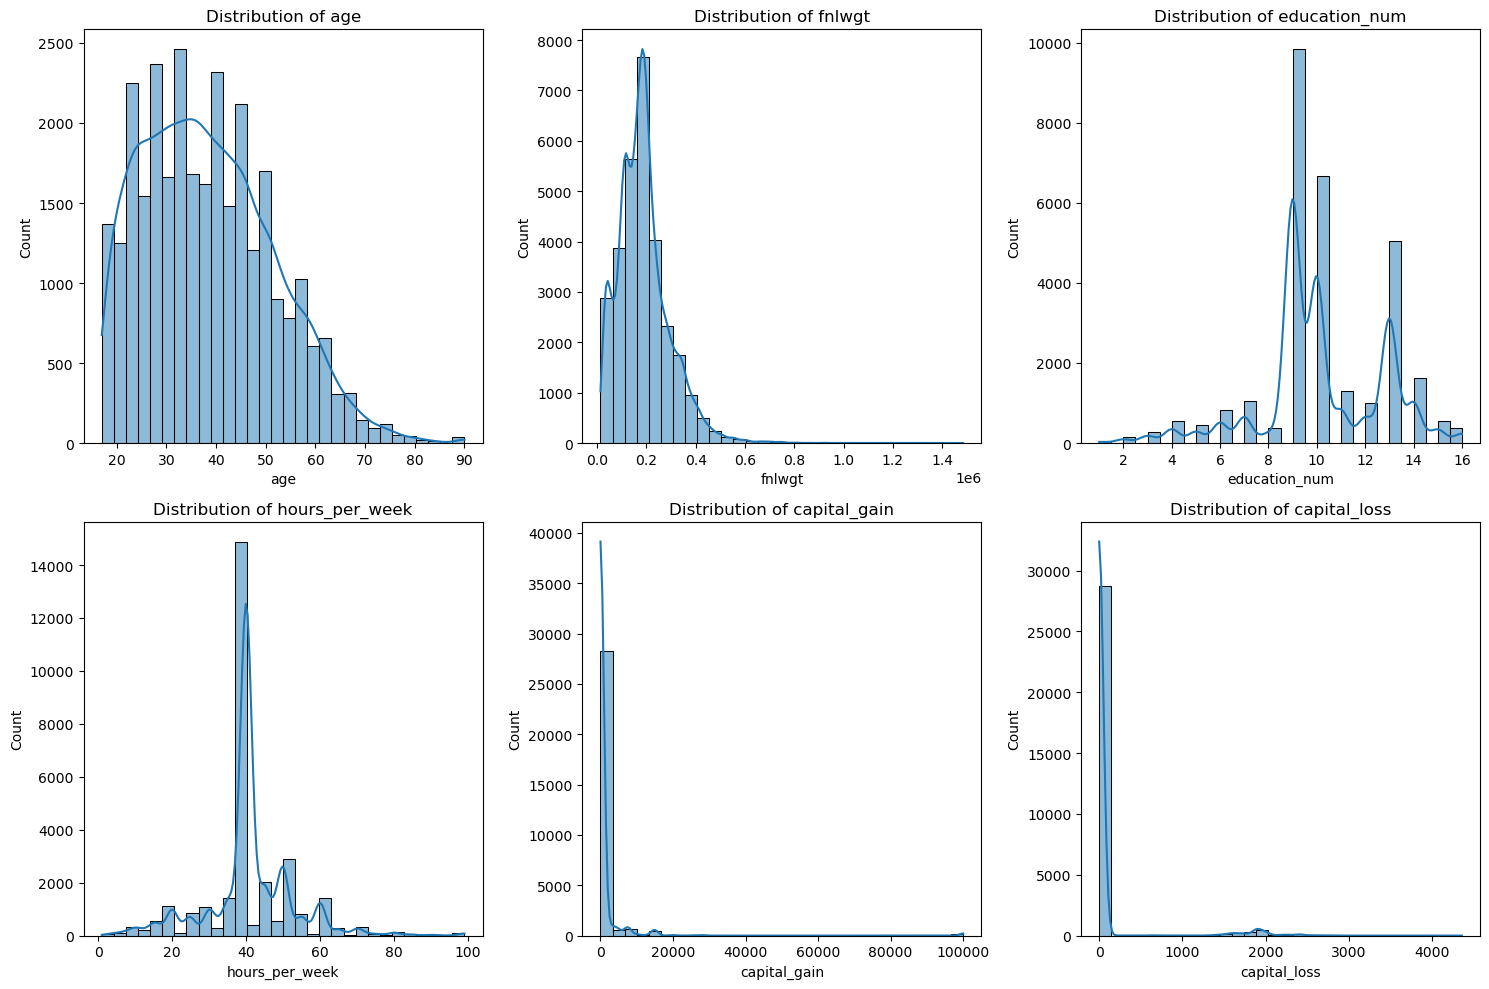

In [3]:
numeric_cols = ['age', 'fnlwgt', 'education_num', 'hours_per_week', 'capital_gain', 'capital_loss']

plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

### Numerical Features
We analyzed the distributions of the following numeric columns: age, fnlwgt, education_num, hours_per_week, capital_gain, and capital_loss.

Age: The distribution is right-skewed, with most individuals between ages 20 and 50. The frequency decreases steadily after 50, indicating fewer older individuals in the dataset.

Fnlwgt: This variable shows a highly skewed distribution and may not be directly interpretable for clustering but is useful for weighted analysis.

Education_num: Displays a multi-modal pattern, with peaks at 9 (HS-grad), 10 (Some-college), 13 (Bachelors), and 14 (Masters), indicating that most individuals fall into these educational categories.

Hours_per_week: Shows a sharp peak at 40 hours, suggesting a large portion of the sample works full time. There are also minor peaks at common part-time or overtime hours.

Capital_gain and Capital_loss: Both are heavily right-skewed with large spikes at zero, meaning most individuals report no gains or losses. A few individuals have very high values, which could act as outliers or indicators of unique financial situations.

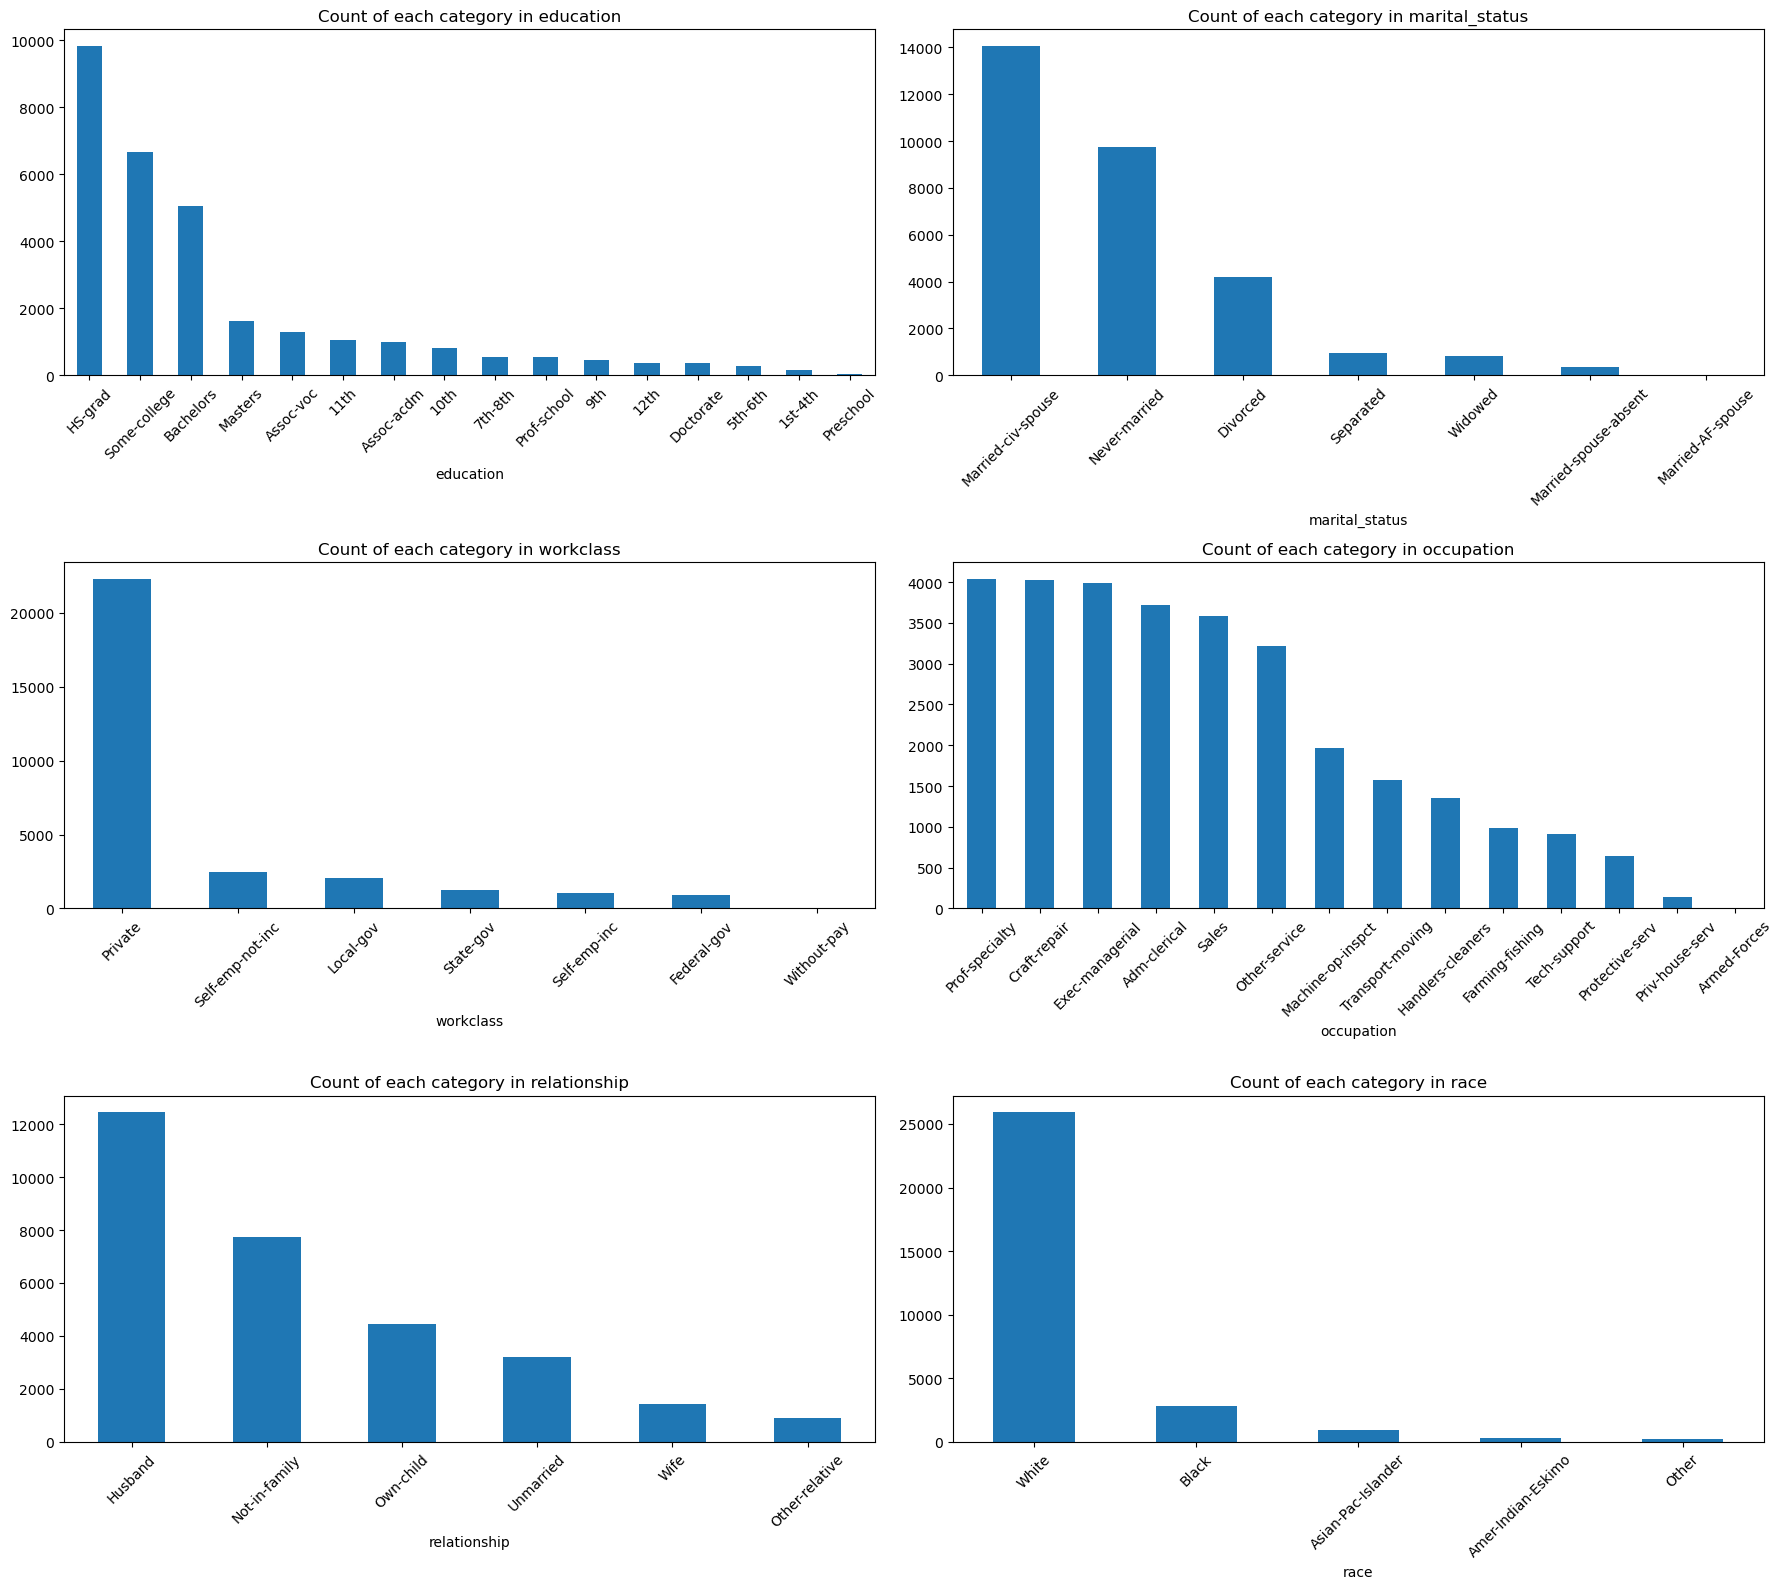

In [4]:
categorical_cols = ['education', 'marital_status', 'workclass', 'occupation', 'relationship', 'race', 'sex', 'native_country']

plt.figure(figsize=(18, 16))
for i, col in enumerate(categorical_cols[:6], 1):  # Just the first 6 to avoid overcrowding
    plt.subplot(3, 2, i)
    df[col].value_counts().sort_values(ascending=False).plot(kind='bar')
    plt.title(f'Count of each category in {col}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Categorical Features
We also explored several key categorical columns: education, marital_status, workclass, occupation, relationship, and race.

Education: "HS-grad", "Some-college", and "Bachelors" dominate, with other categories trailing far behind. This aligns with the numeric education_num distribution.

Marital_status: "Married-civ-spouse" and "Never-married" are the two largest groups, followed by "Divorced".

Workclass: The vast majority fall under "Private", while "Self-emp-not-inc", "Local-gov", and "State-gov" form smaller segments.

Occupation: "Prof-specialty", "Craft-repair", and "Exec-managerial" are the most frequent. The distribution is fairly spread across other roles, suggesting occupational diversity.

Relationship: "Husband" and "Not-in-family" are the most common, indicating a dataset skewed toward individuals not part of a traditional nuclear family structure.

Race: "White" is the dominant group by a large margin, with "Black" being the second most frequent. Other racial categories appear in much smaller numbers.

## 3. Elbow Method to Determine Optimal k

To apply k-means clustering, we must first decide on the number of clusters \( k \).  
One common approach is the **Elbow Method**, which evaluates how the **within-cluster sum of squares (inertia)** decreases as \( k \) increases.

### What Is This Method:
- When \( k \) increases, inertia always decreases (more clusters = tighter groups).
- But after a certain point, the gain in clustering quality becomes minimal.
- The "elbow" in the graph represents a point of **diminishing returns**, where adding more clusters doesn’t significantly improve fit.

### How It's Done:
- We fit k-means for values of \( k \) from 1 to 11.
- For each, we calculate **inertia** (the sum of squared distances from each point to its assigned cluster center).
- Then we plot \( k \) vs. inertia to visually identify the "elbow."


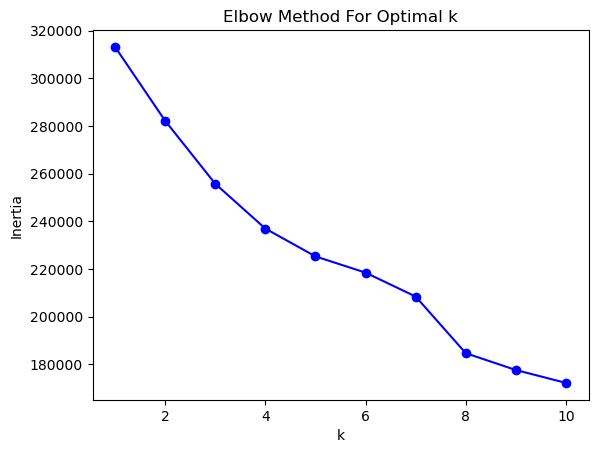

In [5]:
#Set k range to be from 1-11
inertia = []
K = range(1, 11)

#Loop for setting up the plot that generates the "elbow"
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_preprocessed)
    inertia.append(kmeans.inertia_)

#Plot elbow
plt.plot(K, inertia, 'bo-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

## 4. Fit Final Model and Assign Clusters

Based on the elbow plot, we select **k = 3** as the optimal number of clusters. This value represents a good balance between compactness and simplicity — additional clusters beyond **k = 3** showed only marginal improvement in inertia.

### Final Model:
We now fit the **k-means algorithm** using **k = 3** and assign each data point to one of the clusters.  
The resulting cluster labels (0, 1, 2) are stored in a new column called **`cluster`** in the original dataset.

This assignment allows us to:
- Analyze the composition of each cluster
- Compare cluster profiles
- Optionally evaluate how these clusters relate to external labels (like income)

In [6]:
#Based on the elbow plot, we find the optimal k value to be 3
k_final = 3
#Finalize the model with k=3
kmeans = KMeans(n_clusters=k_final, random_state=42)
clusters = kmeans.fit_predict(X_preprocessed)
#Add a column on the original data frame that specifies the cluster each row is in
df['cluster'] = clusters
df

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,cluster
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,0
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,0
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,0
5,34,Private,216864,HS-grad,9,Divorced,Other-service,Unmarried,White,Female,0,3770,45,United-States,0
6,38,Private,150601,10th,6,Separated,Adm-clerical,Unmarried,White,Male,0,3770,40,United-States,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,22,Private,310152,Some-college,10,Never-married,Protective-serv,Not-in-family,White,Male,0,0,40,United-States,1
32557,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,1
32558,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,0
32559,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,0


## 5. Cluster Interpretation

After selecting **k=3** as the optimal number of clusters based on previous analysis, we assigned each adult in the dataset to one of three distinct groups. The table below summarizes the key characteristics of each cluster, showing both the average (mean) values for numeric features and the most common (mode) categories for categorical features, along with counts to provide context on cluster sizes.

In [7]:
#Columns to include, separate numeric and categorical variables
numeric_cols = ['age', 'fnlwgt', 'education_num', 'hours_per_week', 'capital_gain', 'capital_loss']
categorical_cols = ['education', 'marital_status', 'workclass', 'occupation', 'relationship', 'race', 'sex', 'native_country']
all_features = numeric_cols + categorical_cols

#Prepare final table
summary_table = pd.DataFrame(index=[f"{col} (mean)" if col in numeric_cols else f"{col} (mode)"
                                    for col in all_features],
                             columns=[f"Cluster {i}" for i in range(k_final)])

#Fill values with mean/mode + count
for i in range(k_final):
    cluster_data = df[df['cluster'] == i]
    cluster_size = len(cluster_data)
    
    for col in numeric_cols:
        mean_val = round(cluster_data[col].mean(), 2)
        summary_table.loc[f"{col} (mean)", f"Cluster {i}"] = f"{mean_val} (n={cluster_size})"
    
    for col in categorical_cols:
        most_common = cluster_data[col].value_counts().idxmax()
        count = cluster_data[col].value_counts().max()
        summary_table.loc[f"{col} (mode)", f"Cluster {i}"] = f"{most_common} ({count} people)"

#Show table
print("🧾 Final 3-Column Cluster Summary Table (with counts):")
display(summary_table)


🧾 Final 3-Column Cluster Summary Table (with counts):


,Cluster 0,Cluster 1,Cluster 2
age (mean),45.08 (n=15611),31.16 (n=14403),46.18 (n=148)
fnlwgt (mean),178487.69 (n=15611),202012.12 (n=14403),193309.64 (n=148)
education_num (mean),10.61 (n=15611),9.57 (n=14403),12.99 (n=148)
hours_per_week (mean),45.16 (n=15611),36.25 (n=14403),50.26 (n=148)
capital_gain (mean),956.56 (n=15611),222.49 (n=14403),99999.0 (n=148)
capital_loss (mean),145.66 (n=15611),27.19 (n=14403),0.0 (n=148)
education (mode),HS-grad (4855 people),HS-grad (4963 people),Prof-school (45 people)
marital_status (mode),Married-civ-spouse (12586 people),Never-married (8955 people),Married-civ-spouse (122 people)
workclass (mode),Private (10127 people),Private (12081 people),Private (78 people)
occupation (mode),Exec-managerial (2844 people),Adm-clerical (2722 people),Prof-specialty (65 people)


### Observations

**Cluster Sizes:**
Clusters 0 and 1 dominate the dataset with roughly 15,600 and 14,400 members respectively, while Cluster 2 is much smaller with about 150 members. This indicates a highly imbalanced cluster distribution but also suggests that Cluster 2 captures a more unique subgroup.

**Age and Work Hours:**
Cluster 2 members are the oldest on average (46.18 years) and work the longest hours per week (50.26), whereas Cluster 1 is the youngest group (31.16 years) with fewer work hours (36.25). Cluster 0 sits in the middle for both age (45.08) and work hours (45.16).

**Income-Related Variables (Capital Gain/Loss):**
Cluster 2 has a notably high mean capital gain (about 99,999), which is likely driven by outliers or a subset of very high earners. Clusters 0 and 1 have much lower averages here, but Cluster 0 has a higher capital loss than Cluster 1, indicating different financial patterns.

**Education:**
The modal education level for Clusters 0 and 1 is “HS-grad,” while Cluster 2’s most common education is “Prof-school” (professional school), suggesting higher educational attainment in this smaller, more specialized group.

**Marital Status & Relationship:**
Cluster 0 primarily consists of married individuals (“Married-civ-spouse”) and “Husbands,” while Cluster 1 mostly contains never-married people and “Not-in-family” relationships. Cluster 2 resembles Cluster 0 in marital status but with far fewer members.

**Occupation and Workclass:**
Executive/managerial roles dominate Cluster 0, administrative clerical work defines Cluster 1, and professional specialty roles characterize Cluster 2. All clusters are mainly employed in the “Private” sector.

**Race, Sex, and Native Country:**
All clusters are predominantly White and largely consist of individuals from the United States. Cluster 0 is mostly male, while Cluster 1 is majority female, and Cluster 2 returns to majority male.

### Interpretation:
Cluster 0: Middle-aged, married males working full-time in executive/managerial positions with moderate capital gains/losses.

Cluster 1: Younger, never-married females in administrative roles working fewer hours and with lower capital gains.

Cluster 2: Small but distinct group of older, highly educated professionals working long hours with very high capital gains, potentially representing a wealthy or specialized subset.

The differences in demographics, work, and financial variables justify the choice of three clusters and demonstrate the power of unsupervised learning to uncover hidden structure in complex social data.

## 6. PCA Visualization

To visualize the separation and compactness of the clusters, we applied Principal Component Analysis (PCA) to reduce the high-dimensional data into two principal components and plotted the points colored by cluster assignment.

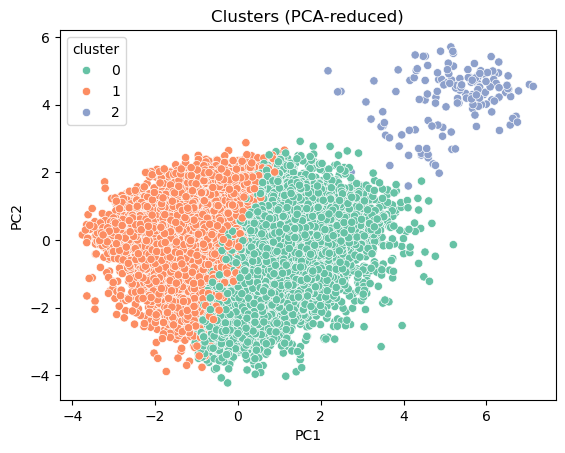

In [8]:
#Set to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_preprocessed)

#Create a new dataframe and add column clusters
df_plot = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_plot['cluster'] = clusters

#Plot
sns.scatterplot(data=df_plot, x='PC1', y='PC2', hue='cluster', palette='Set2')
plt.title('Clusters (PCA-reduced)')
plt.show()

### Key Insights from the PCA Plot:
Clear Cluster Separation:
The PCA plot reveals that Clusters 0 and 1 form two large, mostly contiguous groups with some overlap along the PC1 axis. This partial overlap indicates these clusters share some similarities but still have distinguishable profiles. We see that there are no Cluster 0 data in the middle of Cluster 1 and same way around, which is a good proof that k=3 is the optimal number of clusters.

Distinct Small Cluster:
Cluster 2 is clearly separated from the other two clusters, forming a tight, compact group in the upper-right corner. This visual isolation supports the notion that Cluster 2 represents a unique subgroup within the population. Also, from Step 5, we know that Cluster 2 has very little data points compared to the other clusters, which is also shown clearly here.

Cluster Compactness:
Each cluster appears reasonably compact and internally consistent, indicating the clustering captured coherent groupings rather than random or noisy assignments.

Dimensionality Reduction Limitations:
While PCA provides an intuitive two-dimensional view, it compresses much of the data’s variance. Some overlap in the PCA space may hide finer distinctions that exist in higher dimensions.

### Summary:
The PCA plot validates the cluster assignments visually, showing that k=3 produces meaningful segmentation with two large general groups and one small, distinct niche group. This combined quantitative and visual evidence strengthens confidence in the clustering solution.

## 7. Compare Cluster Distribution with Income to Assess Socioeconomic Patterns

To further interpret the clusters from a socioeconomic lens, we analyzed the distribution of income levels within each cluster. Specifically, we compared the proportion of individuals earning more than 50K and less than or equal to 50K in each group. This helps uncover whether the clusters correspond to distinct economic segments in the adult population.

In [9]:
#Make a original dataframe
original_df = pd.read_csv('https://raw.githubusercontent.com/CharlesMa153/Segmentation-of-Adults/refs/heads/main/adult.csv')
#Remove missing values of new dataframe
original_df.replace("?", np.nan, inplace=True)
original_df.dropna(inplace=True)
#Make it look nicer
original_df.columns = original_df.columns.str.strip().str.lower().str.replace('-', '_').str.replace('.', '_')
#Add column cluster
original_df['cluster'] = clusters
#Generate the proportion of income from different clusters
income_by_cluster = original_df.groupby('cluster')['income'].value_counts(normalize=True)
print(income_by_cluster)

cluster  income
0        <=50K     0.576260
         >50K      0.423740
1        <=50K     0.948275
         >50K      0.051725
2        >50K      1.000000
Name: proportion, dtype: float64


### Key Findings:
Cluster 0 has a mixed income profile, with a substantial 42.37% earning above $50K. This group includes mostly married males in executive roles, making them relatively affluent, though not uniformly so.

Cluster 1 is heavily skewed toward lower-income individuals, with 94.83% earning less than or equal to $50K. It mostly comprises younger, never-married females in administrative roles, which reflects broader trends in income disparity by age, gender, and job type.

Cluster 2 stands out as a uniquely high-income group, with 100% of individuals earning more than $50K. Given its characteristics—older age, high education, long work hours, and high capital gains—this cluster clearly represents a high-earning elite segment.

### Interpretation:
This analysis validates that clustering captures not only demographic or employment differences but also significant economic stratification within the population. Clusters are not arbitrarily defined — they reflect real-world patterns in education, occupation, and income.

## 8. Analyze Clustering Performance

To objectively evaluate the quality of the clustering, we calculated two commonly used clustering performance metrics:

- Calinski-Harabasz Score (CH): Measures within-cluster compactness and between-cluster separation. Higher is better.

- Davies-Bouldin Score (DB): Measures average similarity between each cluster and its most similar one. Lower is better.

In [10]:
X_dense = X_preprocessed.toarray()
ch_score = calinski_harabasz_score(X_dense, clusters)
db_score = davies_bouldin_score(X_dense, clusters)
print(f"Calinski-Harabasz Score:  {ch_score:.2f}   (higher is better)")
print(f"Davies-Bouldin Score:     {db_score:.4f}  (lower is better)")

Calinski-Harabasz Score:  3386.87   (higher is better)
Davies-Bouldin Score:     1.9722  (lower is better)


### Interpretation:
The high Calinski-Harabasz score indicates that the clusters are well-separated and internally consistent — especially notable given the dataset’s size and complexity.

The moderate Davies-Bouldin score suggests some overlap exists between clusters (0 and 1), but this is expected due to shared features like workclass and race.

Together with the PCA visualization, these metrics support the conclusion that k=3 produces meaningful and stable clusters.

## 9. Conclusion and Insights

This project applied unsupervised learning (clustering) to segment adults from the U.S. Census dataset based on demographic, educational, occupational, and financial attributes. Through a thorough workflow — including data preprocessing, optimal k selection via the elbow method, PCA visualization, and performance scoring — we arrived at a reliable segmentation of the adult population into three distinct clusters.

### Summary of Clusters:
Cluster 0: Middle-aged, married male professionals — a mixed-income group with moderate capital activity and managerial roles.

Cluster 1: Younger, predominantly female administrative workers — mostly low-income with fewer work hours and lower education levels.

Cluster 2: Highly educated, older professionals — a small but high-income group with distinct features (e.g., high capital gain, long hours, professional schooling).

### Key Takeaways:
- Clustering uncovers latent structure in the data that aligns with real-world social and economic patterns.

- The clusters reflect income inequality, differences in gender roles, educational attainment, and occupational segmentation.

- PCA visualization and performance metrics validate the robustness and interpretability of the clusters.

- This analysis can serve as a foundation for policy research, socioeconomic studies, or as a preprocessing step for supervised models (e.g., predicting income or targeting interventions using classification).

This analysis demonstrates how unsupervised learning can uncover complex, meaningful social groupings without direct labels. The clustering revealed the similarities/differences within society and distinct segments of the population—such as a low-income, younger administrative group; a mixed-income managerial class; and a small, high-income elite with advanced education and long work hours.

From a real-world perspective, these findings echo and quantify many well-known trends in labor and social stratification. They highlight the ongoing gender divide in earnings and job roles, the socioeconomic benefit of higher education (more likely to have a job with higher income), and the distinct profile of high-income professionals in the U.S. population. Importantly, these clusters show that inequality is multi-dimensional, cutting across age, education, occupation, and family status—not just income alone. 

In the end, this project ultimately reflects how data science can intersect with social insight to better understand the structures underlying economic inequalities, as well as patterns and potential actions that could fit in certain clusters/groups.